In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Set2", 10))

In [2]:
def plot_bandit_results(data, eps, title1, title2):
    f, (ax0, ax1) = sns.plt.subplots(1,2, figsize=(10,3))
    ax0.set_title(title1)
    ax1.set_title(title2)
    for l, cd in enumerate(data):
        cm = np.mean(cd, axis=1)
        ax0.plot(cm, label=u"\u03B5 = {}".format(eps[l]))
        ax1.plot(np.cumsum(cm), label=u"\u03B5 = {}".format(eps[l]))
    ax0.legend(loc='best');
    ax1.legend(loc='best');

### 2.1 Testing the testbed

*Which method will perform best in the long run in terms of cumulative reward and cumulative probability of selecting the best action? How much better will it be? Express your answer quantitatively.*

As we can see from the plots below, ε-greedy strategy with tuned ε can be ~30% better in terms of cumulative reward than just greedy strategy. Though, if we choose some crazy ε, it may be much worse than a greedy algorithm.

In [3]:
N_EPOCHS = 1000
EPS = [0,0.01,0.1, 0.2, 0.3, 0.5]
N_BANDITS = 10
N_EXPERIMENTS = 2000


def run_bandit_experiment(n_bandits=10, n_epochs=1000, n_exp=2000, eps=[0,0.01,0.1]):
    rewards = np.zeros((len(eps), n_epochs, n_exp))
    best_actions = np.zeros((len(eps), n_epochs, n_exp))
    for exp in range(n_exp):
        #generate a problem
        q = np.random.normal(size=n_bandits)
        
        best_bandit = np.argmax(q)
        for e in range(len(eps)):
            Q = np.zeros(n_bandits)
            N = np.zeros(n_bandits)
            for i in range(n_epochs):
                #noisy_reward = np.array([np.random.normal(loc=Q[i]) for i in range(N_BANDITS)])
                REWS = [np.random.normal(loc=q[i]) for i in range(n_bandits)]
                if np.random.random() < eps[e]:
                    cb = np.random.randint(n_bandits)
                else:
                    cb = np.argmax(Q)
                R = REWS[cb]
                N[cb]+=1
                Q[cb]+=(R-Q[cb])/N[cb]
                rewards[e][i][exp]=R
                if cb == best_bandit:
                    best_actions[e][i][exp] = 1
    return rewards, best_actions

In [4]:
stat_r, stat_ba = run_bandit_experiment(N_BANDITS, N_EPOCHS, N_EXPERIMENTS, EPS)

#### Stationary problem

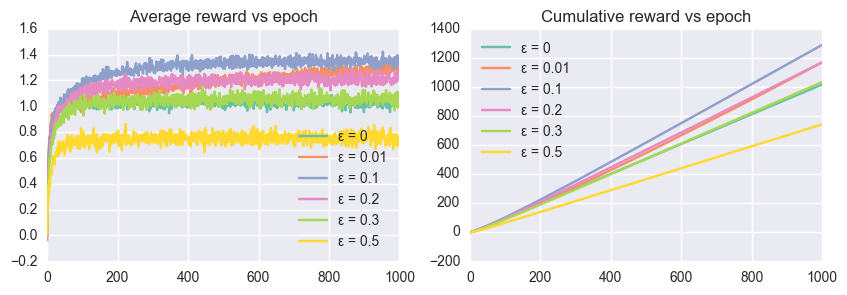

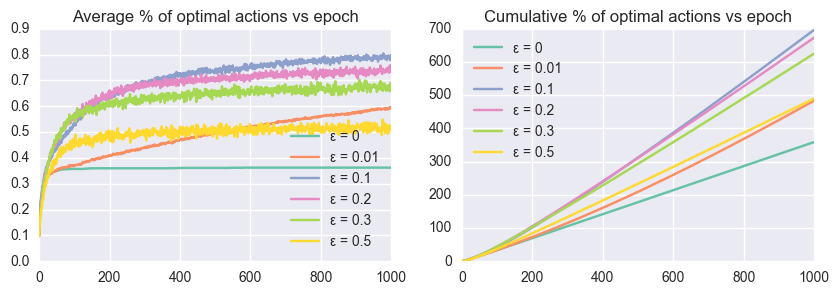

In [5]:
plot_bandit_results(stat_r, EPS, 'Average reward vs epoch', 'Cumulative reward vs epoch')
plot_bandit_results(stat_ba, EPS, 'Average % of optimal actions vs epoch', 'Cumulative % of optimal actions vs epoch')

### 2.2 Playing with the step-size in nonstationary problems

*If the step-size parameters, $α_n$ , are not constant, then the estimate
$Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?*

As far as I get the exercise, we just need to rederive formula (2.6) with different $α$ for each step. Let's go.

$\begin{align}
Q_{n+1} &\doteq Q_n + \alpha_n[R_n - Q_n]\\
&= \alpha_nR_n + (1-\alpha_n)Q_n\\
&= \alpha_nR_n + (1-\alpha_n)[\alpha_{n-1}R_{n-1} + (1-\alpha_{n-1})Q_{n-1}]\\
&= \alpha_nR_n + (1-\alpha_n)\alpha_{n-1}R_{n-1} + (1-\alpha_n)(1-\alpha_{n-1})Q_{n-1}\\
&= \alpha_nR_n + (1-\alpha_n)\alpha_{n-1}R_{n-1} + (1-\alpha_n)(1-\alpha_{n-1})\alpha_{n-2}R_{n-2} + ... + (1-\alpha_n)*...*(1-\alpha_2)\alpha_1 R_1 + (1-\alpha_n)*...*(1-\alpha_1)Q_1\\
&= Q_1 * \prod_{i=1}^{n}(1-\alpha_i) + \sum_{i=1}^{n}[\alpha_iR_i\prod_{j=i+1}^{n}(1-\alpha_j)]
\end{align}$



### 2.3 Nonstationary bandits

*Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q∗(a) start out equal and then take independent random walks. Prepare plots like Figure 2.2 for an actionvalue method using sample averages, incrementally computed by α = 1
n, and another
action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and,
if necessary, runs longer than 1000 steps.*

In [12]:
def run_nonstationary_bandit_experiment(n_bandits, n_epochs, n_exp, eps, alphas):
    rewards = np.zeros((len(alphas), n_epochs, n_exp))
    best_actions = np.zeros((len(alphas), n_epochs, n_exp))
    for exp in range(n_exp):
        #generate a problem
        #q = np.random.normal(size=n_bandits)
        q = [0.5 for b in range(n_bandits)]
        best_bandit = np.argmax(q)
        for e in range(len(alphas)):
            Q = np.zeros(n_bandits)
            N = np.zeros(n_bandits)
            for i in range(n_epochs):
                #independent random walk for each of the bandits
                q += np.random.normal(size=len(q))
                REWS = [np.random.normal(loc=q[i]) for i in range(n_bandits)]
                if np.random.random() < eps:
                    cb = np.random.randint(n_bandits)
                else:
                    cb = np.argmax(Q)
                R = REWS[cb]
                N[cb]+=1
                #Q[cb]+=(R-Q[cb])/N[cb]
                Q[cb]+= alphas[e][i]*(R-Q[cb])
                rewards[e][i][exp]=R
                if cb == best_bandit:
                    best_actions[e][i][exp] = 1
    return rewards, best_actions

In [7]:
def plot_nonstat_bandit_results(data, lbls, title1, title2):
    f, (ax0, ax1) = sns.plt.subplots(1,2, figsize=(10,3))
    ax0.set_title(title1)
    ax1.set_title(title2)
    for l, cd in enumerate(data):
        cm = np.mean(cd, axis=1)
        ax0.plot(cm, label=lbls[l])
        ax1.plot(np.cumsum(cm), label=lbls[l])
    ax0.legend(loc='best');
    ax1.legend(loc='best');

In [13]:
NONSTAT_EPS = 0.1
alphas = [[0.1]*N_EPOCHS, [1/(n+1) for n in range(N_EPOCHS)]]
lbls = ['constant alpha', 'decaying alpha']
nonstat_r, nonstat_ba = run_nonstationary_bandit_experiment(N_BANDITS, N_EPOCHS, N_EXPERIMENTS, NONSTAT_EPS, alphas)

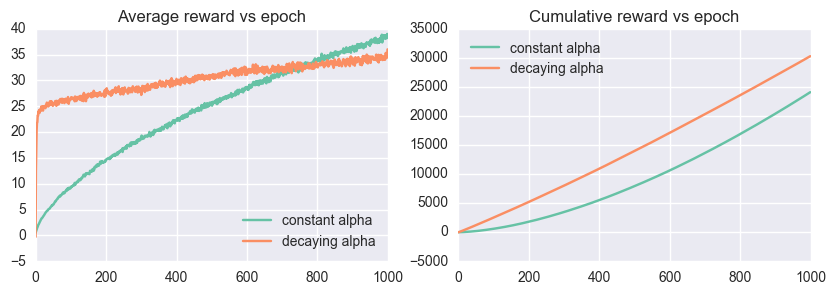

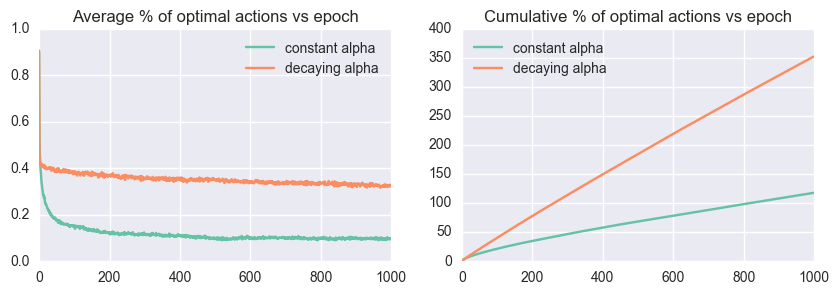

In [14]:
plot_nonstat_bandit_results(nonstat_r, lbls, 'Average reward vs epoch', 'Cumulative reward vs epoch')
plot_nonstat_bandit_results(nonstat_ba, lbls, 'Average % of optimal actions vs epoch', 'Cumulative % of optimal actions vs epoch')

### 2.4 Spiking bandits.

*The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better
or worse, on average, on particular early steps*

I believe, the reason is the following. The less we use the bandit, the more important $R-Q$ in the update. Since $Q$ is too optimistic and $N(A)$ is small, we add a large amount to our $Q$ and have a spike. The further we go, the close the estimate is to the real reward $R$, hence, the smaller is the amount we add to our new estimate (moreover, multiplied by $N(A)$).

### 2.5 UCB spike.

*In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: if c = 1, then the spike is much less prominent*

Okay, if $c=1$ and spike is less prominent, then the answer is in the $\sqrt{log(t)/N_t(a)}$. There is one interesting thing about $N_t(a)$.  If $N_t(a) = 0$, then $a$ is considered to be a maximizing action. So, first ten (number of bandits) epochs we choose bandits we have not tried one by one without using the value inside a square root. And after that we start to take decisions based on this value. 

At first, we take each bandit once and our rewards are somewhere around initial bandit rewards distribution. Then we take the best bandit, given the information avaliable and have a spike. After that 'best so far' bandit gets less appealing since $N_t(a)$ for it is $2$ and $1$ for others, so, we take another bandit and go down in terms of the reward.